<a href="https://colab.research.google.com/github/vg-rlo/TIL/blob/master/ML/modified_baseline_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 위성 관측 데이터 활용 강수량 산출 
* [Dacon 경진대회 링크](https://dacon.io/competitions/official/235591/overview/description)
* [Baseline 코드 링크](https://dacon.io/competitions/official/235591/codeshare/915?page=1&dtype=recent)

## 구글 드라이브 공유문서함의 파일 불러오기 및 경로 설정
* project_path: 공유 문서함 경로
* root_path: 본인 드라이브의 프로젝트 경로

In [ ]:
# 아래 링크의 공유문서함에 있는 "Project_2" 혹은 "ModuWeather" 폴더를 "바로가기 추가"로 내 드라이브에 옮겨온다.
# https://drive.google.com/drive/folders/1AKaRkxZhP5JYQgZFqgR2oD_tzhrL_Xbc # train dataset만 있는 공유문서함

# https://drive.google.com/drive/folders/12YelZ4B4ZA-qzSfstp62JQBjWvigs_Nq # train, test dataset 모두 있는 공유문서함

In [ ]:
# 구글 드라이브와 마운트한다.
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 현재 경로 확인 
!pwd

/content


![image](https://user-images.githubusercontent.com/69677950/130542296-9582ae15-0ed4-49bf-b732-f2a3a4605b9f.png)


In [ ]:
# 경로를 복사해준 후, 해당 경로로 이동한다 => 접근하는 경로를 프로젝트 경로 이후부터 고려해줄 수 있습니다.
# train dataset만 있는 공유문서함을 활용한 경우
# %cd /content/drive/MyDrive/Project_2 

# train dataset만 있는 공유문서함을 활용한 경우
project_path = '/content/drive/MyDrive/ModuWeather/'
project_path

'/content/drive/MyDrive/ModuWeather/'

In [ ]:
# 본인 드라이브의 프로젝트 경로로 설정해주시면 됩니다!
%cd /content/drive/MyDrive/ModuWeather/

/content/drive/MyDrive/ModuWeather


In [ ]:
# 현재 경로 다시 확인
!pwd

/content/drive/MyDrive/ModuWeather


In [ ]:
# 디렉토리의 파일 리스트를 확인한다.
!ls

'baseline_using_unet의 사본'    save	        test
 modified_baseline_using_unet   savetest.npy    test.npy
 origin			        savetrain.npy   train
 project_2_readme.docx	        submission      train.npy


In [ ]:
import os 

# train_path를 설정한다.
# train_path = project_path + '/train'
train_path = os.path.join(project_path, 'train')
train_path

'/content/drive/MyDrive/ModuWeather/train'

## Colab에서 ML/DL Modeling 위한 기초 셋팅

### Runtime 끊김 방지
1. 크롬 브라우저에서 colab을 엽니다.
2. F12 개발자모드에서 콘솔창 하단에 아래의 코드 입력합니다.
3. 런타임 다시 시작을 해줍니다. 
4. 해당 창/탭을 가장 상단에 활성화해둬야합니다. 
```
function ClickConnect(){
    console.log("10분마다 코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button").shadowRoot.querySelector("#connect-icon").click();
}setInterval(ClickConnect,60000*10)
```

In [ ]:
# Runtime 끊김 방지하는 다른 방법
# 맨 하단에 무한루프문을 추가하여 계속 활성화상태를 유지하도록 합니다.

### Out of memory 방지
> 기본적으로 TensorFlow와 그걸 백엔드로 사용하는 Keras는 메모리 파편화를 방지하기 위해서 GPU 메모리를 최대한 매핑한다. 그러다 보니까, 메모리가 필요 이상으로 잡혀 있어서, 정작 필요한 곳에서는 할당을 못해줘서 두 번째 에러 메세지를 나타내는 메모리 초과 문제가 발생할 수 있다. [- TensorFlow, Keras GPU 메모리 문제(Out of Memory) 발생 시 시도해볼 방법](https://twinparadox.tistory.com/606)

* [공식문서](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/gpu.ipynb)
* [공식문서 한글버전](https://www.tensorflow.org/guide/gpu?hl=ko)

In [ ]:
import tensorflow as tf

# TF 버전 확인 및 GPU 연결 여부 확인
print(f'Tensorflow version: {tf.__version__}')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version: 2.6.0
Found GPU at: /device:GPU:0


In [ ]:
# Out of memory 방지를 위한 코드
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# 연결된 GPU 자원 무엇인지 확인 e.g. Tesla P4
!nvidia-smi # 런타임 유형 gpu로 설정 후 실행

Fri Aug 27 06:35:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    54W / 149W |    121MiB / 11441MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Seed 고정
* 참고 자료
    - [Reproduction 을 위한 Seed 고정(Seed everything)](https://dacon.io/codeshare/2363)
    - [Providing determinism in deep learning frameworks](https://github.com/NVIDIA/framework-determinism)
    - 관련 키워드: determinism in tensorflow

In [ ]:
# 재생산성을 위해 시드 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

## 디렉토리의 파일 구성을 확인하는 법
(생각해보기) 아래 3가지 방법의 차이점은 무엇이 있을까?

### 리눅스 명령어를 사용한 방법

In [ ]:
# tree 명령어를 사용하기 위한 패키지 설치
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (97.2 kB/s)
Selecting previously unselected package tree.
(Reading database ... 148489 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# 디렉토리의 구성을 level 2까지 보여주는 리눅스 명령어
!tree -L 1

.
├── baseline_using_unet의 사본
├── modified_baseline_using_unet
├── origin
├── project_2_readme.docx
├── save
├── savetest.npy
├── savetrain.npy
├── submission
├── test
├── test.npy
├── train
└── train.npy

5 directories, 7 files


### os 라이브러리를 사용한 방법

In [ ]:
project_path

'/content/drive/MyDrive/ModuWeather/'

In [ ]:
# os.getcwd() 사용한 현재 경로
# root_path = os.getcwd()
root_path = './' # .은 현재 경로를 의미
root_path

'./'

In [ ]:
import os

proj_list = os.listdir(project_path)
print (f'root_list: {proj_list}')

root_list: ['project_2_readme.docx', 'train', 'test', 'submission', 'savetrain.npy', 'save', 'test.npy', 'train.npy', 'origin', 'baseline_using_unet의 사본', 'savetest.npy', 'modified_baseline_using_unet']


In [ ]:
proj_list = os.listdir(project_path)
print (f'root_list: {proj_list}')

root_list: ['project_2_readme.docx', 'train', 'test', 'submission', 'savetrain.npy', 'save', 'test.npy', 'train.npy', 'origin', 'baseline_using_unet의 사본', 'savetest.npy', 'modified_baseline_using_unet']


In [ ]:
data_path = os.path.join(project_path, 'train')
file_list = os.listdir(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['subset_019829_10.npy', 'subset_022820_07.npy', 'subset_024561_03.npy', 'subset_013374_05.npy', 'subset_025356_08.npy', 'subset_018501_11.npy', 'subset_014358_11.npy', 'subset_025494_01.npy', 'subset_025062_04.npy', 'subset_015219_12.npy', 'subset_014337_05.npy', 'subset_019244_07.npy', 'subset_018425_04.npy', 'subset_015020_07.npy', 'subset_019163_01.npy', 'subset_019844_11.npy', 'subset_019906_09.npy', 'subset_018132_11.npy', 'subset_024725_03.npy', 'subset_020736_12.npy', 'subset_024818_02.npy', 'subset_026730_06.npy', 'subset_027306_08.npy', 'subset_024869_03.npy', 'subset_018831_04.npy', 'subset_014143_03.npy', 'subset_014727_09.npy', 'subset_016785_05.npy', 'subset_018708_07.npy', 'subset_016995_09.npy', 'subset_013850_10.npy', 'subset_022779_08.npy', 'subset_018539_06.npy', 'subset_024640_05.npy', 'subset_025355_02.npy', 'subset_025402_04.npy', 'subset_022235_08.npy', 'subset_012585_07.npy', 'subset_024871_04.npy', 'subset_020612_05.npy', 'subset_012523_11.npy', 'sub

In [ ]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = os.path.join(project_path, 'train')
data_list = os.listdir(data_path)
data_list = [data for data in data_list if data.endswith('.npy')]
print (f'data_list: {data_list}')
print(f'data 개수: {len(data_list)}')

data_list: ['subset_019829_10.npy', 'subset_022820_07.npy', 'subset_024561_03.npy', 'subset_013374_05.npy', 'subset_025356_08.npy', 'subset_018501_11.npy', 'subset_014358_11.npy', 'subset_025494_01.npy', 'subset_025062_04.npy', 'subset_015219_12.npy', 'subset_014337_05.npy', 'subset_019244_07.npy', 'subset_018425_04.npy', 'subset_015020_07.npy', 'subset_019163_01.npy', 'subset_019844_11.npy', 'subset_019906_09.npy', 'subset_018132_11.npy', 'subset_024725_03.npy', 'subset_020736_12.npy', 'subset_024818_02.npy', 'subset_026730_06.npy', 'subset_027306_08.npy', 'subset_024869_03.npy', 'subset_018831_04.npy', 'subset_014143_03.npy', 'subset_014727_09.npy', 'subset_016785_05.npy', 'subset_018708_07.npy', 'subset_016995_09.npy', 'subset_013850_10.npy', 'subset_022779_08.npy', 'subset_018539_06.npy', 'subset_024640_05.npy', 'subset_025355_02.npy', 'subset_025402_04.npy', 'subset_022235_08.npy', 'subset_012585_07.npy', 'subset_024871_04.npy', 'subset_020612_05.npy', 'subset_012523_11.npy', 'sub

In [ ]:
pwd

'/content/drive/MyDrive/ModuWeather'

### glob 라이브러리를 사용한 방법

In [ ]:
import glob

# path = './*'
path = project_path + '*'
dir_list = glob.glob(path)
print (f'dir_list: {dir_list}')

dir_list: ['/content/drive/MyDrive/ModuWeather/project_2_readme.docx', '/content/drive/MyDrive/ModuWeather/train', '/content/drive/MyDrive/ModuWeather/test', '/content/drive/MyDrive/ModuWeather/submission', '/content/drive/MyDrive/ModuWeather/savetrain.npy', '/content/drive/MyDrive/ModuWeather/save', '/content/drive/MyDrive/ModuWeather/test.npy', '/content/drive/MyDrive/ModuWeather/train.npy', '/content/drive/MyDrive/ModuWeather/origin', '/content/drive/MyDrive/ModuWeather/baseline_using_unet의 사본', '/content/drive/MyDrive/ModuWeather/savetest.npy', '/content/drive/MyDrive/ModuWeather/modified_baseline_using_unet']


In [ ]:
data_path = project_path + 'train/*'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['/content/drive/MyDrive/ModuWeather/train/subset_019829_10.npy', '/content/drive/MyDrive/ModuWeather/train/subset_022820_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_024561_03.npy', '/content/drive/MyDrive/ModuWeather/train/subset_013374_05.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025356_08.npy', '/content/drive/MyDrive/ModuWeather/train/subset_018501_11.npy', '/content/drive/MyDrive/ModuWeather/train/subset_014358_11.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025494_01.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025062_04.npy', '/content/drive/MyDrive/ModuWeather/train/subset_015219_12.npy', '/content/drive/MyDrive/ModuWeather/train/subset_014337_05.npy', '/content/drive/MyDrive/ModuWeather/train/subset_019244_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_018425_04.npy', '/content/drive/MyDrive/ModuWeather/train/subset_015020_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_019163_01.npy', '/content/dri

In [ ]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = project_path + 'train/*.npy'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['/content/drive/MyDrive/ModuWeather/train/subset_019829_10.npy', '/content/drive/MyDrive/ModuWeather/train/subset_022820_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_024561_03.npy', '/content/drive/MyDrive/ModuWeather/train/subset_013374_05.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025356_08.npy', '/content/drive/MyDrive/ModuWeather/train/subset_018501_11.npy', '/content/drive/MyDrive/ModuWeather/train/subset_014358_11.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025494_01.npy', '/content/drive/MyDrive/ModuWeather/train/subset_025062_04.npy', '/content/drive/MyDrive/ModuWeather/train/subset_015219_12.npy', '/content/drive/MyDrive/ModuWeather/train/subset_014337_05.npy', '/content/drive/MyDrive/ModuWeather/train/subset_019244_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_018425_04.npy', '/content/drive/MyDrive/ModuWeather/train/subset_015020_07.npy', '/content/drive/MyDrive/ModuWeather/train/subset_019163_01.npy', '/content/dri

In [ ]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = project_path + 'test/*.npy'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['/content/drive/MyDrive/ModuWeather/test/subset_030458_12.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030458_01.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030448_10.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030459_02.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030458_10.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030456_02.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030448_03.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030448_06.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030449_04.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030448_04.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030457_08.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030457_02.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030457_06.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030449_06.npy', '/content/drive/MyDrive/ModuWeather/test/subset_030434_04.npy', '/content/drive/MyDrive/Modu

## 라이브러리 및 데이터
## Library & Data

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
 
warnings.filterwarnings('ignore')

In [ ]:
# 경로 확인
print(root_path) # 내 드라이브의 프로젝트 경로 
print(project_path) # 공유 드라이브의 프로젝트 경로

./
/content/drive/MyDrive/ModuWeather/


In [ ]:
# train set 경로 설정
train_path = project_path + 'train'
train_files = sorted(glob.glob(train_path + '/*'))
train_files[:5]

['/content/drive/MyDrive/ModuWeather/train/subset_010468_04.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010468_05.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010468_06.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010471_01.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010484_05.npy']


*   밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기

*   약 ~~7만장~~4천장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용해보기




In [ ]:
def trainGenerator():
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        dataset = np.load(file)
        # 강수량에 결측값은 0으로 일괄 대체
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:9]
        
        # 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용
        if (cutoff_labels > 0).sum() < 50:
            continue

        yield (feature, cutoff_labels)

In [ ]:
dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]),tf.TensorShape([40,40,1])))

In [ ]:
# datatset shuffle
dataset = dataset.shuffle(3)
dataset

<ShuffleDataset shapes: ((40, 40, 9), (40, 40, 1)), types: (tf.float32, tf.float32)>

In [ ]:
# # 시간 걸림 Dataset => numpy array iterator
# len(list(dataset.as_numpy_iterator()))

In [ ]:
DATASET_SIZE = len(train_files)
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
print(train_size, val_size, test_size)

2862 357 357


In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)
test_dataset = dataset.skip(test_size)

In [ ]:
BATCH_SIZE = 64 # baseline: 512, 128
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(1) 
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(1)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(1)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 40, 40, 9), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [ ]:
# test set 경로 설정
test_path = project_path + 'test'
test_files = sorted(glob.glob(test_path + '/*'))
test_files[:5]

['/content/drive/MyDrive/ModuWeather/test/subset_029858_01.npy',
 '/content/drive/MyDrive/ModuWeather/test/subset_029858_02.npy',
 '/content/drive/MyDrive/ModuWeather/test/subset_029858_03.npy',
 '/content/drive/MyDrive/ModuWeather/test/subset_029858_05.npy',
 '/content/drive/MyDrive/ModuWeather/test/subset_029858_07.npy']

In [ ]:
# # test set 불러오기 - 약 3~4분 소요(인터넷 환경따라 차이 있음)
# X_test = []
# for file in tqdm(test_files, desc = 'test'):
#     data = np.load(file)
#     # 밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기
#     X_test.append(data[:,:,:9])

In [ ]:
# X_test = np.array(X_test)
# X_test[0][0][0]

In [ ]:
project_path+'save/test.npy'

'/content/drive/MyDrive/ModuWeather/save/test.npy'

In [ ]:
# np.save(save_path+'test.npy', X_test) # 공유문서함에 저장된 test.npy를 불러오는 코드
# np.save(project_path+'save/test', X_test)

In [ ]:
X_test = np.load(project_path+'save/test.npy')
X_test[0][0][0]

array([187.87782288, 117.11814117, 227.91667175, 182.93215942,
       262.49633789, 252.47938538, 222.88275146, 283.04528809,
       279.37545776])

## 데이터 전처리 (Data Cleansing & Pre-Processing)
* 데이터 불러올 시 전처리 로직 적용
* 강수량에 결측값은 0으로 일괄 대체

In [ ]:
train_path

'/content/drive/MyDrive/ModuWeather/train'

In [ ]:
train_files[:5]

['/content/drive/MyDrive/ModuWeather/train/subset_010468_04.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010468_05.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010468_06.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010471_01.npy',
 '/content/drive/MyDrive/ModuWeather/train/subset_010484_05.npy']

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 40, 40, 9), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [ ]:
if not os.path.isdir(root_path+'save'):
    print("현재 경로에 save 폴더가 없습니다. 새로 생성합니다.")
    os.mkdir(root_path+'save')

save_path = os.path.join(root_path, 'save')
save_path

'./save'

## 탐색적 자료분석(EDA, Exploratory Data Analysis)
* 밝기 온도와 강수량과의 관계 확인해보기

#### 질문
* numpy array 형태가 좀더 시각화가 편한데, tf.data.Dataset 대신 전처리된 numpy array를 사용해도 되는지?

In [ ]:
train_files[0]

'/content/drive/MyDrive/ModuWeather/train/subset_010468_04.npy'

In [ ]:
image_sample = np.load(train_files[0])
image_sample.shape

(40, 40, 15)

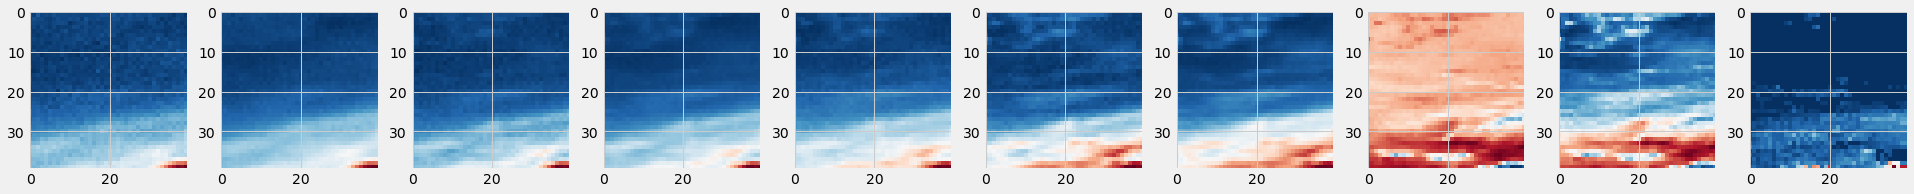

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()
plt.tight_layout() # figure 크기에 맞게 layout 정렬

## 변수 선택 및 모델 구축 (Feature Engineering & Initial Modeling)
* 모델 구축
* [활용한 코드1](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) 
* [활용한 코드2](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification)

## 모델 학습 및 검증 (Model Tuning & Evaluation)
#### Tuning 할 수 있는 요소들 어떤 것들 있을까?
* BatchNormalization layer과 Dropout layer의 필요성
    - Trial1: Baseline model, epochs=30, lr=0.001, batch_size=512 => 13.02590
    - Trial2: Baseline model, epochs=30, lr=0.001, batch_size=128 => 3.06330
    - Trial3: Basdline model without Dropout, epochs=50, lr=5e-4, batch_size=128 => 2.90014
    - Trial4: Basdline model without Dropout, epochs=50, lr=1e-4, batch_size=64 => 3.05472

        * Dropout이 왜 효과가 있었을까? [링크](https://22-22.tistory.com/40)

In [ ]:
BATCH_SIZE

64

In [ ]:
EPOCHS = 50
LR = 1e-4 # 0.001, 1e-4, 1e-5 = 1 × 10−5

In [ ]:
LR

0.0001

### 모델 구축(Build)

In [ ]:
def build_model(input_layer, start_neurons):
    # Down sampling 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    # pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    # pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    # uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    # uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

In [ ]:
input_layer = Input((40, 40, 9))
input_layer

<KerasTensor: shape=(None, 40, 40, 9) dtype=float32 (created by layer 'input_1')>

In [ ]:
output_layer = build_model(input_layer, 32)

In [ ]:
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 9)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 32)   2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 32)   128         conv2d_1[0][0]                   
______________________________________________________________________________________________

* Loss fuction 정의
* [TensorFlow에 custom metrics 적용하는 코드](https://dacon.io/competitions/official/235584/codeshare/738)

In [ ]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def mae_over_fscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def mae_over_fscore_keras(y_true, y_pred):
    score = tf.py_function(func=mae_over_fscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

### 모델 학습(Fit, Train)

In [ ]:
import datetime

# file 덮어쓰기 방지하기 위해 time log 변수 정의
time_log = datetime.datetime.now().strftime('%m%d_%H%M') # "strftime": string formatting time
time_log = datetime.datetime.now()
kst_log = time_log + datetime.timedelta(hours=9)
kst_log = kst_log.strftime('%m%d_%H%M') # "strftime": string formatting time
kst_log

'0827_1535'

In [ ]:
# lr scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1 * (10-epoch))

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, CSVLogger, ModelCheckpoint

lr = LearningRateScheduler(scheduler(EPOCHS, LR), verbose=1)
es = EarlyStopping(monitor='val_mae_over_fscore_keras', patience=3) # loss 부분 mae ~ 로 수정
csv_log = CSVLogger(os.path.join(save_path, f'log_{kst_log}.csv'), append=True, separator=',') # training_log, append=False이면 덮어쓰기
cp = ModelCheckpoint(save_path+f'/model_{kst_log}.h5', monitor='val_mae_over_fscore_keras', save_best_only=True, verbose=1) # loss 부분 mae ~ 로 수정

In [ ]:
model.compile(loss="mae", optimizer="adam", metrics=[mae_over_fscore_keras, fscore_keras])

In [ ]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[es, cp, csv_log], verbose=1)

Epoch 1/50
45/45 [==============================] - 560s 13s/step - loss: 0.9666 - mae_over_fscore_keras: 3.1305 - fscore_keras: 0.6818 - val_loss: 1.1933 - val_mae_over_fscore_keras: 2414.1870 - val_fscore_keras: 0.0014

Epoch 00001: val_mae_over_fscore_keras improved from inf to 2414.18701, saving model to ./save/model_0827_1535.h5
Epoch 2/50
45/45 [==============================] - 22s 488ms/step - loss: 0.8592 - mae_over_fscore_keras: 2.5999 - fscore_keras: 0.7420 - val_loss: 1.1650 - val_mae_over_fscore_keras: 30.1429 - val_fscore_keras: 0.0990

Epoch 00002: val_mae_over_fscore_keras improved from 2414.18701 to 30.14285, saving model to ./save/model_0827_1535.h5
Epoch 3/50
45/45 [==============================] - 22s 486ms/step - loss: 0.8334 - mae_over_fscore_keras: 2.4675 - fscore_keras: 0.7578 - val_loss: 1.0021 - val_mae_over_fscore_keras: 5.8873 - val_fscore_keras: 0.3986

Epoch 00003: val_mae_over_fscore_keras improved from 30.14285 to 5.88729, saving model to ./save/model_0

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'mae_over_fscore_keras', 'fscore_keras', 'val_loss', 'val_mae_over_fscore_keras', 'val_fscore_keras'])

### 모델 학습 결과 시각화(Visualization)

In [ ]:
def vis(history,name) :
    # plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'train {name}')

    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'val {name}')
    plt.legend(loc='best', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(15, 5))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

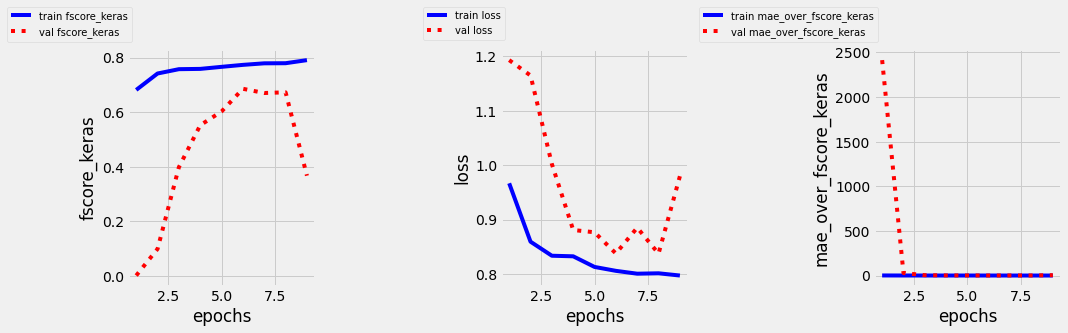

In [ ]:
plot_history(model_history)

### 모델 불러오기(Load)

In [ ]:
model_name = 'model_0827_1535'
save_path = root_path + 'save'
model_path = save_path+f'/{model_name}.h5'
model_path

'./save/model_0827_1535.h5'

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(model_path, compile=False)

In [ ]:
# 위의 모델을 다시 이어서 학습하고 싶으면, model.compile부터 다시 실행
model.compile(loss="mae", optimizer="adam", metrics=[mae_over_fscore_keras, fscore_keras])

In [ ]:
# 모델 재학습 (Transfer Learning, Fine Tuning)
# model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[es, cp, csv_log], verbose=1)

### 검증(Evaluation)

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None, 40, 40, 9), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [ ]:
# dataset에서 spli한 test 셋으로 성능 확인 => 해당 결과 지표로 hyper parmeter tuning 수행
results = model.evaluate(test_dataset)
print(f'loss, mae over fscore, fscore: {results}')

41/41 [==============================] - 12s 240ms/step - loss: 0.8372 - mae_over_fscore_keras: 2.7915 - fscore_keras: 0.6864
loss, mae over fscore, fscore: [0.8372321128845215, 2.7914788722991943, 0.6863883137702942]


In [ ]:
# Report
# epoch=30, batch_size=128, lr=0.001, validation split=0.1, shuffle=True
'loss, mae over fscore, fscore: [0.9267109036445618, 2.3121776580810547, 0.7835437059402466]'

'loss, mae over fscore, fscore: [0.9267109036445618, 2.3121776580810547, 0.7835437059402466]'

### 예측(Predict)

In [ ]:
X_test.shape

(2416, 40, 40, 9)

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred.shape

(2416, 40, 40, 1)

In [ ]:
X_test[0,:,:,:] == X_test[6,:,:,:] # 다른 데이터임을 확인

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
pred[0,:,:,:] == pred[6,:,:,:]

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

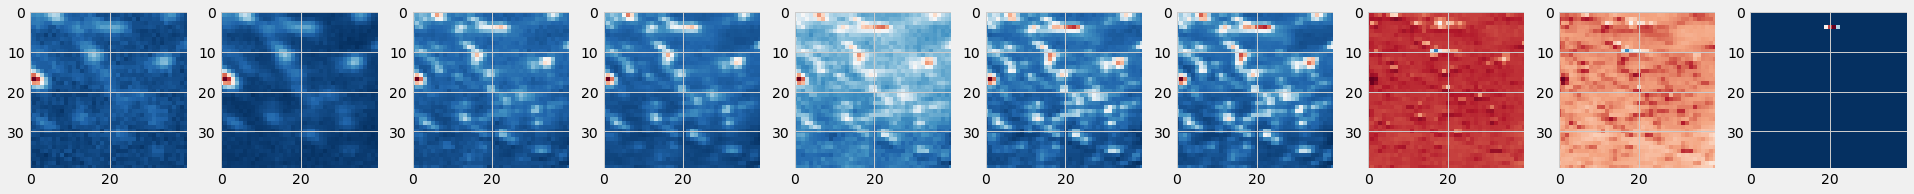

<Figure size 432x288 with 0 Axes>

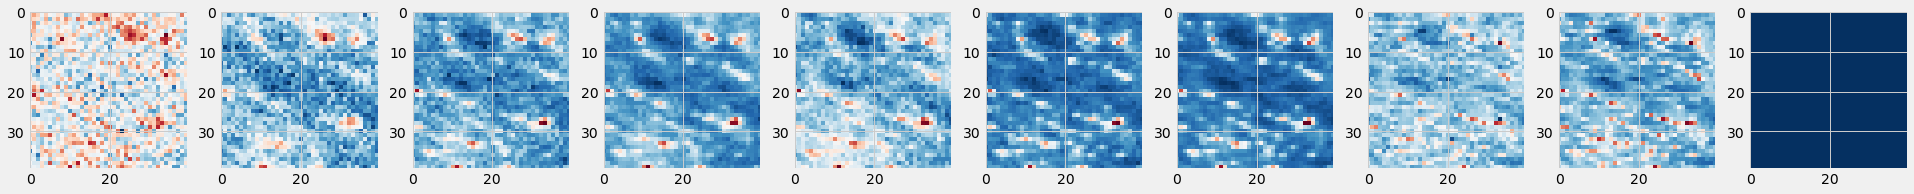

<Figure size 432x288 with 0 Axes>

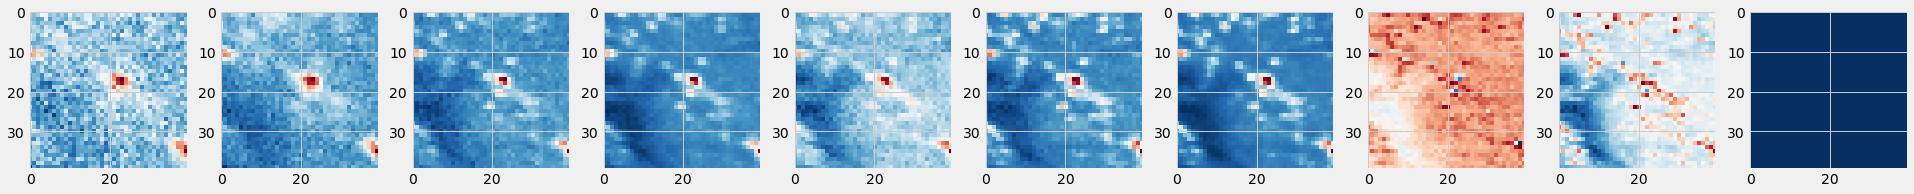

<Figure size 432x288 with 0 Axes>

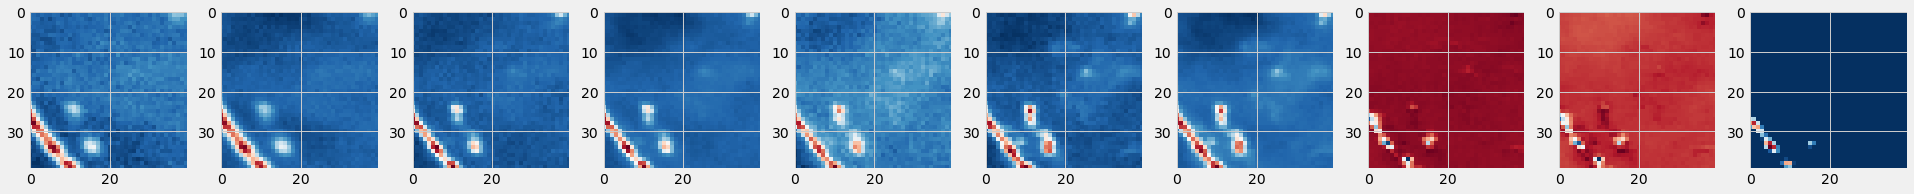

<Figure size 432x288 with 0 Axes>

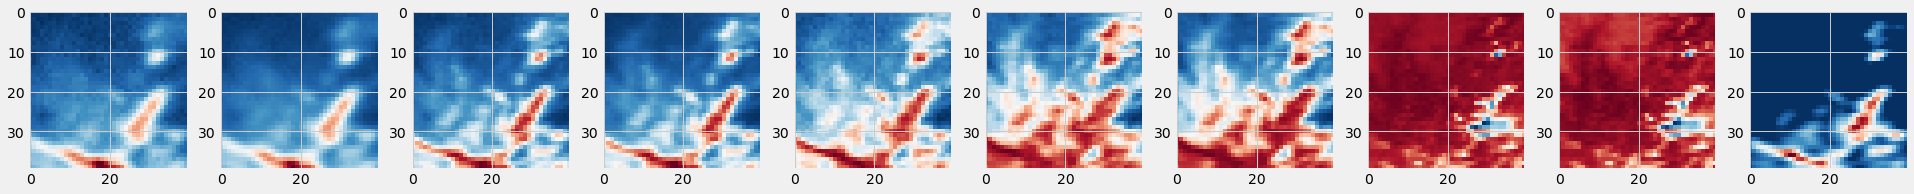

<Figure size 432x288 with 0 Axes>

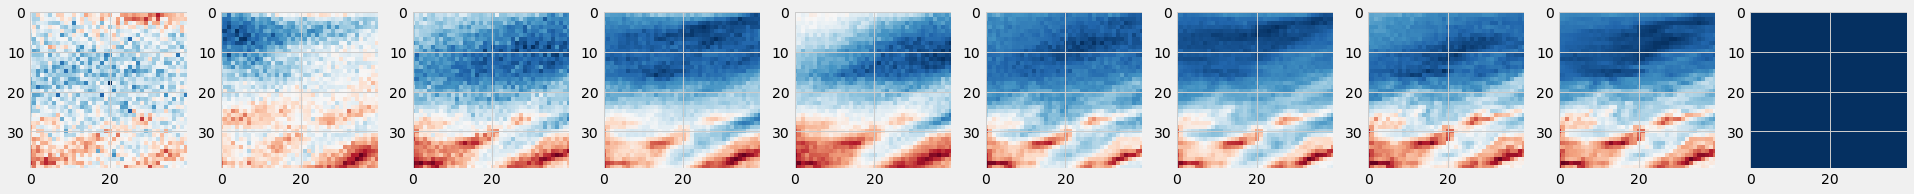

<Figure size 432x288 with 0 Axes>

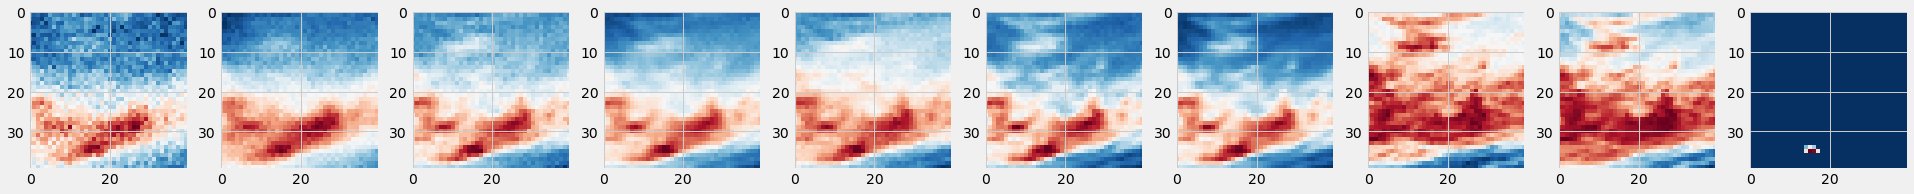

<Figure size 432x288 with 0 Axes>

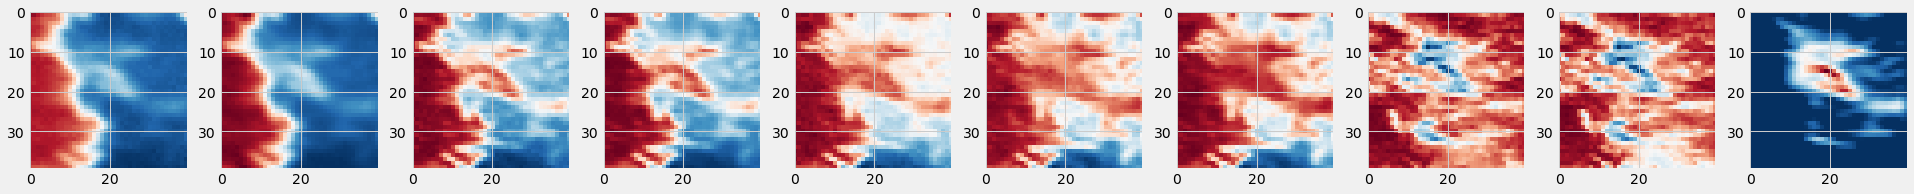

<Figure size 432x288 with 0 Axes>

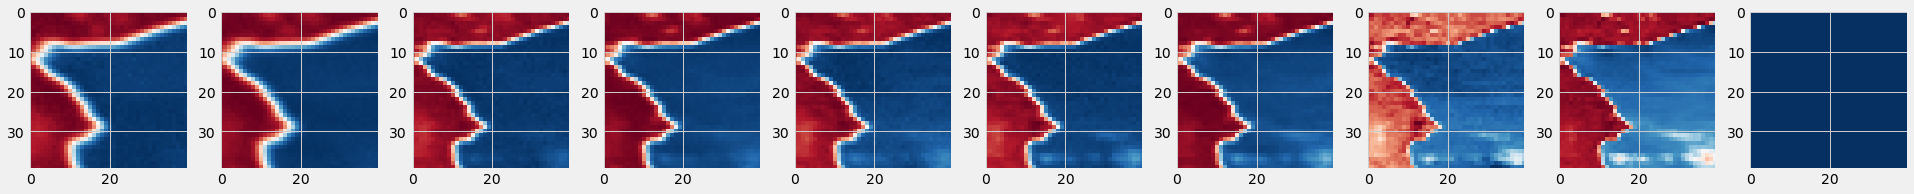

<Figure size 432x288 with 0 Axes>

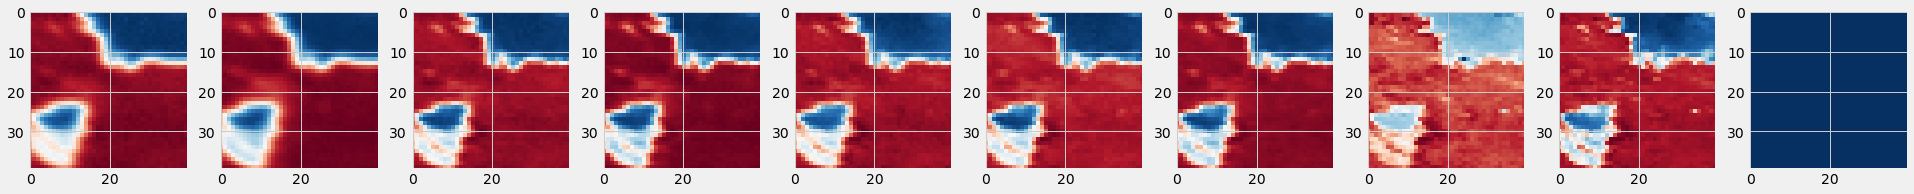

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns

nums = 10 # nums 개수 만큼 Xtest와 pred 결과 확인

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

plt.style.use('fivethirtyeight')

div_n = 1
for idx in range(0, nums, div_n): # nums개 / divn 개 시각화 
    h = 6*int(nums/div_n)
    plt.figure(figsize=(30, h)) #
    for i in range(9):
        plt.subplot(idx+1,10,i+1)
        plt.imshow(X_test[idx, :, :, i], cmap=color_map)

    plt.subplot(idx+1,10,10)
    plt.imshow(pred[idx, :, :, -1], cmap = color_map) 
    plt.show()
    plt.tight_layout() # figure 크기에 맞게 layout 정렬

## 제출 파일 생성
제출 파일을 생성할 때는 쓰기 권한이 필요합니다. 따라서 본인 드라이브의 프로젝트 경로인 root_path로 지정해줘야합니다.

In [ ]:
if not os.path.isdir(root_path+'submission'):
    print("현재 경로에 submission 폴더가 없습니다. 새로 생성합니다.")
    os.mkdir(root_path+'submission')

save_path = os.path.join(root_path, 'submission')
save_path

'./submission'

In [ ]:
submission = pd.read_csv(os.path.join(root_path, 'submission/sample_submission.csv'))
submission.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_18,px_19,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_28,px_29,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_38,px_39,...,px_1561,px_1562,px_1563,px_1564,px_1565,px_1566,px_1567,px_1568,px_1569,px_1570,px_1571,px_1572,px_1573,px_1574,px_1575,px_1576,px_1577,px_1578,px_1579,px_1580,px_1581,px_1582,px_1583,px_1584,px_1585,px_1586,px_1587,px_1588,px_1589,px_1590,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(pred.shape)
print(submission.iloc[:,1:].shape)

(2416, 40, 40, 1)
(2416, 1600)


In [ ]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [ ]:
submission_file = f'./submission/{model_name}_subtime_{kst_log}.csv'
submission_file

'./submission/model_0827_1535_subtime_0827_1535.csv'

In [ ]:
submission.to_csv(submission_file, index = False)

## Dacon API 활용하여 제출 
* [튜토리얼](https://dacon.io/forum/403588?dtype=recent)

In [ ]:
# 먼저 https://bit.ly/3gMPScE 링크에서 파일을 다운로드 후 submission 폴더 하위에 저장한다.
!pip install ./submission/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./submission/dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [ ]:
from dacon_submit_api import dacon_submit_api 


```
result = dacon_submit_api.post_submission_file(
'파일경로', 
'개인 Token', # 계정관리에서 각자 개인 토큰 활용해주세요!
'대회ID', # https://dacon.io/competitions/official/235591/overview/prize 대회 링크에 있는 6자리 번호
'팀이름', 
'submission 메모 내용' ) # 정확도나, 시도 사항들을 기록해두는 것이 좋습니다.
```


![image](https://user-images.githubusercontent.com/69677950/130543113-e711437a-161b-4891-8834-836d0e868cbe.png)


In [ ]:
result = dacon_submit_api.post_submission_file(
    submission_file,  # 파일 경로
    '',  # 꼭 계정관리의 본인 토큰 활용해주세요!
    '235591',  # 대회 번호
    'vg-rlo',  # 팀 이름/계정 이름
    f'batch size: {BATCH_SIZE}, epoch: {EPOCHS}, lr: {LR}'  # 메모 내용 e.g. 변경사항/시도사항
    )

{'isSubmitted': True, 'detail': 'Success'}


**API 활용한 제출 결과**
![image](https://user-images.githubusercontent.com/69677950/130542269-33a9b0fe-c88f-4c18-85e5-548549ba24d2.png)

## 결과 및 결언 (Conclusion & Discussion)
* 밝기 온도 차의 채널별로 Min, Max가 다르기 때문에 ./255 보다는 MinMaxScaling
* 강수량이 있는 곳, 없는 곳
* Dropout alpha값을 어떻게 수정했는지 

## Runtime 끊김 방지를 위한 무한 루프

In [ ]:
# while True:
#     pass